# Chapter 3 Questions

#### 3.1 Form dollar bars for E-mini S&P 500 futures:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [4]:
import numpy as np
import pandas as pd

from mlfinlab.corefns.core_functions import CoreFunctions

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv', nrows=20000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [7]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [8]:
# Compute daily volatility
vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=100)

Calculating daily volatility for dynamic thresholds


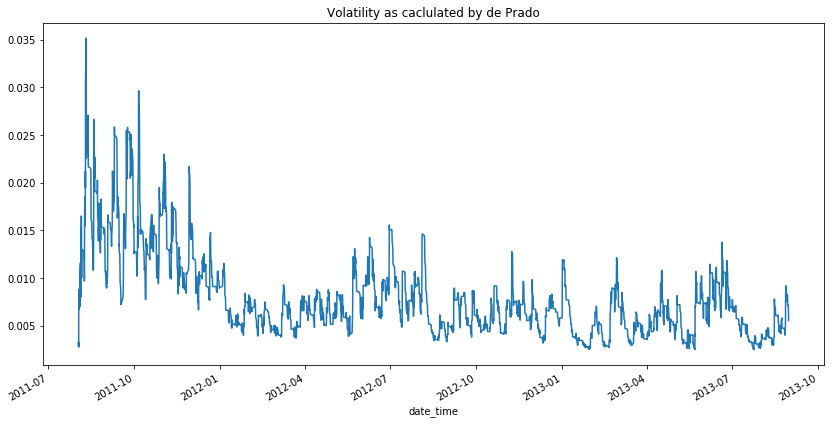

In [9]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [10]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=vol.mean())

Applying Symmetric CUSUM filter.


100%|███████████████████████████████████████████████████████████████████████████████| 19998/19998 [00:02<00:00, 6965.12it/s]


**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [11]:
# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2011-08-01 13:46:23.650   2011-08-02 13:50:40.053
2011-08-01 14:01:38.747   2011-08-02 14:04:29.869
2011-08-01 15:38:23.090   2011-08-02 15:49:00.114
2011-08-01 19:25:42.891   2011-08-02 19:26:07.927
2011-08-02 07:31:03.237   2011-08-03 08:02:36.120
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [12]:
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=[1, 1],
                                  target=vol,
                                  min_ret=0.01,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=None)

D:\Documents\WQU\Courses\14 - Capstone 690\cs\chapter3\mlfinlab\corefns\core_functions.py:182: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [13]:
triple_barrier_events.head()

,t1,trgt
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326,0.011060
2011-08-04 09:53:01.844,2011-08-04 13:50:40.606,0.011529
2011-08-04 12:43:40.327,2011-08-04 15:01:19.020,0.010884
2011-08-04 19:30:23.101,2011-08-05 06:36:24.009,0.010586
2011-08-04 19:53:02.682,2011-08-05 12:30:19.803,0.012946


In [14]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

In [15]:
labels.head()

,ret,trgt,bin
2011-08-04 01:57:00.466,-0.016254,0.011060,-1
2011-08-04 09:53:01.844,-0.012014,0.011529,-1
2011-08-04 12:43:40.327,-0.011109,0.010884,-1
2011-08-04 19:30:23.101,-0.012435,0.010586,-1
2011-08-04 19:53:02.682,0.014829,0.012946,1


In [16]:
labels['bin'].value_counts()

 0    201
 1    175
-1    136
Name: bin, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [17]:
clean_labels = CoreFunctions.drop_labels(labels)

In [18]:
print(labels.shape)
print(clean_labels.shape)

(512, 3)
(512, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

In [21]:
close_prices = data['close']
print(len(close_prices))
close_prices.head()

20000


date_time
2011-07-31 23:31:58.810    1305.75
2011-08-01 02:55:17.443    1306.50
2011-08-01 07:25:56.319    1305.00
2011-08-01 08:33:10.903    1300.00
2011-08-01 10:51:41.842    1307.75
Name: close, dtype: float64

Define the window size for crossover lines

In [28]:
short_window = 3
long_window = 7

Create a data frame with the close prices and the rolling moving averages

In [40]:
signal_df = (pd.DataFrame()
             .assign(price=close_prices)
             .assign(short_ma=close_prices.ewm(short_window).mean())
             .assign(long_ma=close_prices.ewm(long_window).mean())
            )
signal_df['signal'] = 0.
signal_df.head(20)

,price,short_ma,long_ma,signal
date_time,,,,
2011-07-31 23:31:58.810,1305.75,1305.750000,1305.750000,0.0
2011-08-01 02:55:17.443,1306.50,1306.178571,1306.150000,0.0
2011-08-01 07:25:56.319,1305.00,1305.668919,1305.714497,0.0
2011-08-01 08:33:10.903,1300.00,1303.595714,1303.988348,0.0
2011-08-01 10:51:41.842,1307.75,1304.957426,1304.953684,0.0
2011-08-01 12:10:26.542,1303.50,1304.514182,1304.624023,0.0
2011-08-01 13:05:38.802,1302.00,1303.788811,1304.083927,0.0
2011-08-01 13:30:25.769,1303.50,1303.708576,1303.972726,0.0
2011-08-01 13:34:11.222,1302.75,1303.449477,1303.754177,0.0


Create a signal when the short MA crosses over the long MA.
Ensure that this is done for the period that is larger than the shortest MA window

In [48]:
def get_up_crosses(df):
    crit1 = df.short_ma.shift(1) < df.long_ma.shift(1)  # previous value was below
    crit2 = df.short_ma > df.long_ma  # this value is above
    return df.short_ma[(crit1) & (crit2)]

def get_down_crosses(df):
    crit1 = df.short_ma.shift(1) > df.long_ma.shift(1)  # previous value was above
    crit2 = df.short_ma < df.long_ma  # this value is below
    return df.short_ma[(crit1) & (crit2)]

def create_side_series(up, down):
    # indices for the up signal
    up_points = pd.Series(1, index=up.index)

    # indices for the down signal
    down_points = pd.Series(-1, index=down.index)
    
    side = pd.concat([up_points, down_points]).sort_index()
    return side

In [39]:
up = get_up_crosses(signal_df)
down = get_down_crosses(signal_df)
print(up.head())

date_time
2011-08-01 10:51:41.842    1304.957426
2011-08-01 19:07:22.748    1276.955613
2011-08-02 13:58:04.741    1276.133557
2011-08-03 13:07:43.154    1252.345743
2011-08-03 15:17:23.195    1241.700169
Name: short_ma, dtype: float64

Compute side

In [50]:
side = create_side_series(up, down)
print(side.value_counts())
print(side.head(10))

 1    603
-1    603
dtype: int64
date_time
2011-08-01 07:25:56.319   -1
2011-08-01 10:51:41.842    1
2011-08-01 12:10:26.542   -1
2011-08-01 19:07:22.748    1
2011-08-02 07:31:03.237   -1
2011-08-02 13:58:04.741    1
2011-08-02 14:27:55.423   -1
2011-08-03 13:07:43.154    1
2011-08-03 13:31:30.677   -1
2011-08-03 15:17:23.195    1
dtype: int64


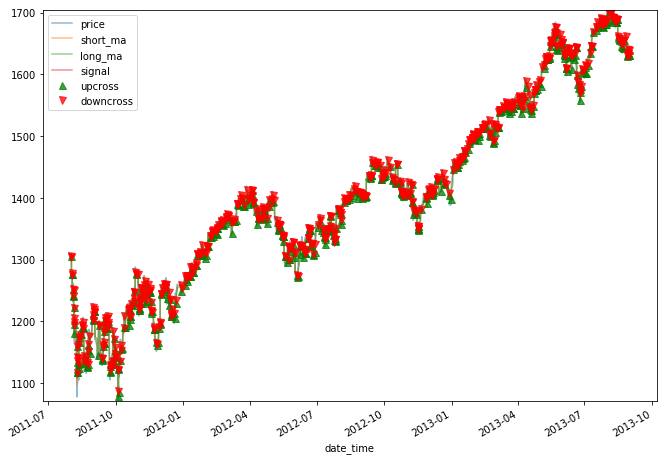

In [51]:
max_value = np.max(signal_df.price)
min_value = np.min(signal_df.price)

f, ax = plt.subplots(figsize=(11,8))

signal_df.loc['2011':].plot(ax=ax, alpha=.5)
up.loc['2011':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2011':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')
plt.ylim(min_value, max_value)
ax.legend()

In [35]:
signal_df.head(20)

,price,short_ma,long_ma,signal
date_time,,,,
2011-07-31 23:31:58.810,1305.75,1305.750000,1305.750000,0.0
2011-08-01 02:55:17.443,1306.50,1306.178571,1306.150000,0.0
2011-08-01 07:25:56.319,1305.00,1305.668919,1305.714497,0.0
2011-08-01 08:33:10.903,1300.00,1303.595714,1303.988348,0.0
2011-08-01 10:51:41.842,1307.75,1304.957426,1304.953684,1.0
2011-08-01 12:10:26.542,1303.50,1304.514182,1304.624023,0.0
2011-08-01 13:05:38.802,1302.00,1303.788811,1304.083927,0.0
2011-08-01 13:30:25.769,1303.50,1303.708576,1303.972726,0.0
2011-08-01 13:34:11.222,1302.75,1303.449477,1303.754177,0.0


On those sampled features, apply the triple-barrier method, where ptSl=[1,2] and t1 earlier

In [72]:
# Compute daily volatility
# vol = CoreFunctions.get_daily_vol(close=close_prices, lookback=100)

# Apply Symmetric CUSUM Filter and get timestamps for events
# cusum_events = CoreFunctions.get_t_events(close_prices, threshold=vol.mean())

# Compute vertical barrier
# vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, close_prices)

ma_events = CoreFunctions.get_events(close_prices,                                     
                                     t_events=cusum_events,
                                     pt_sl=[1, 2],
                                     target=vol,
                                     min_ret=0.01,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)


D:\Documents\WQU\Courses\14 - Capstone 690\cs\chapter3\mlfinlab\corefns\core_functions.py:182: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
D:\Documents\WQU\Courses\14 - Capstone 690\cs\chapter3\mlfinlab\corefns\core_functions.py:194: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_ = side.loc[target.index]


In [73]:
print(ma_events.head())
print(ma_events.side.value_counts())

                         side                      t1      trgt
2011-08-04 01:57:00.466   NaN 2011-08-05 03:04:02.365  0.011060
2011-08-04 09:53:01.844   NaN 2011-08-05 10:40:27.497  0.011529
2011-08-04 12:43:40.327   NaN 2011-08-05 12:47:59.454  0.010884
2011-08-04 19:30:23.101   NaN 2011-08-05 19:31:31.852  0.010586
2011-08-04 19:53:02.682   NaN 2011-08-05 19:55:20.902  0.012946
-1.0    26
 1.0    26
Name: side, dtype: int64


In [74]:
ma_events.dropna(inplace=True)
print(ma_events.head())
print(ma_events.side.value_counts())

                         side                      t1      trgt
2011-08-05 12:30:19.803   1.0 2011-08-05 15:51:03.471  0.015896
2011-08-05 14:26:25.267   1.0 2011-08-05 15:57:57.407  0.012784
2011-08-05 14:46:02.504  -1.0 2011-08-05 15:51:03.471  0.012299
2011-08-05 19:05:26.371  -1.0 2011-08-07 22:01:50.370  0.011735
2011-08-08 19:16:11.723   1.0 2011-08-08 23:56:13.676  0.014773
-1.0    26
 1.0    26
Name: side, dtype: int64


In [75]:
labels = CoreFunctions.get_bins(ma_events, close_prices)

In [76]:
print(labels.head())

                              ret      trgt  bin
2011-08-05 12:30:19.803 -0.032929  0.015896    0
2011-08-05 14:26:25.267 -0.031204  0.012784    0
2011-08-05 14:46:02.504  0.013644  0.012299    1
2011-08-05 19:05:26.371  0.023051  0.011735    1
2011-08-08 19:16:11.723 -0.035371  0.014773    0


(3.4b) Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1) 

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

C:\Users\Asingh\Anaconda3\envs\p36\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Asingh\Anaconda3\envs\p36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.69      1.00      0.82        18
           1       0.00      0.00      0.00         8

   micro avg       0.69      0.69      0.69        26
   macro avg       0.35      0.50      0.41        26
weighted avg       0.48      0.69      0.57        26



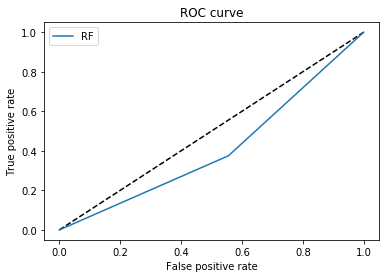

In [83]:
X = ma_events.side.to_frame()
y = labels.bin.to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10_000
c_random_state = 777

rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train)
# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
